# **Dimensionality Reduction**

Having a small dataset is not the only issue attached to the data. Since we are studying the connections between seventy-six different regions of the brain,our data is composed of two thousand and eighty features. This enormous space of features adds a significant amount of complexity to the problem. The combination of a small dataset and a huge amount of features implies that the results from modeling won't be great and far from generalizable.

To avoid this issue, since we can't get more data to deal with such a complex problem, the only solution consists of reducing the number of features. However, applying dimensionality reduction techniques, such as PCA, Kernel PCA, or LDA, will have the unwanted effect of losing interpretability. Since our main interest is to understand the effects of the disease on brain connection, losing interpretability is not an option. 

In this notebook we'll finish preprocessing data by solving a problem related to zero-values which clearly have a negative impact in terms of model performance. After that, we'll test three different techniques to reduce dimensionality without losing interpretability, Principal Component decomposition of PCA, Random Forest Feature Importance, and Clustering (KMeans). 

## Index

**1. Libraries**

**2. Load the data**

**3. Data Preprocessing**

· *3.1. Zero-Values Problem*

· *3.2. Imputation*

**4. Dimensionality Reduction**

· *4.1. Evaluation Metric: Logistic Regression*

· *4.2. FA Data*

 - 4.2.1. PCA Feature Extraction

 - 4.2.2. Random Forest: Feature Importance

 - 4.2.3. Clustering

· *4.3. GM Networks Data*

 - 4.3.1. Zero Problem Visualization

 - 4.3.2. Imputation and reference evaluation

 - 4.3.3. Random Forest: Feature Importance

· *4.4. Functional Data*

 - 4.4.1. Zero Problem Visualization

 - 4.4.2. Imputation and reference evaluation

 - 4.4.3. Random Forest: Feature Importance

· *4.5. GM + Func Data*

 - 4.5.1. Imputation and reference evaluation

 - 4.5.2. Random Forest: Feature Importance

· *4.6. FA + GM + Func Data*

 - 4.6.1. Imputation and reference evaluation

 - 4.6.2. Random Forest: Feature Importance

## *1. Libraries*

In [57]:
# Data Load Code
from load_data import data_loader

# Preprocessing functions
from preprocessing import connectivity_test, linear_correction, harmonization
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.preprocessing import StandardScaler

# Dimensionality Reduction Techniques
from sklearn.decomposition import PCA

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import f1_score, recall_score, precision_score

# Basic Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## *2. Load the data*

In [58]:
full_dataset, fa, func, gm = data_loader(unzip=False)

## *3. Data Preprocessing*

### *3.1. Zero Value Problem*

In [59]:
# Clinical Data

clinical_data = fa.iloc[:, -5:]

# Connectivity test
index = connectivity_test(fa.iloc[:, :-5], clinical_data)

fa_conec = fa.iloc[:, index]
func_conec = func.iloc[:, index]
gm_conec = gm.iloc[:, index]

# age and sex corrections
fa_correct = linear_correction(clinical_data, fa_conec)
func_correct = linear_correction(clinical_data, func_conec)
gm_correct = linear_correction(clinical_data, gm_conec)

# harmonization
fa_har = harmonization(fa_correct.iloc[:, :-5], clinical_data)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


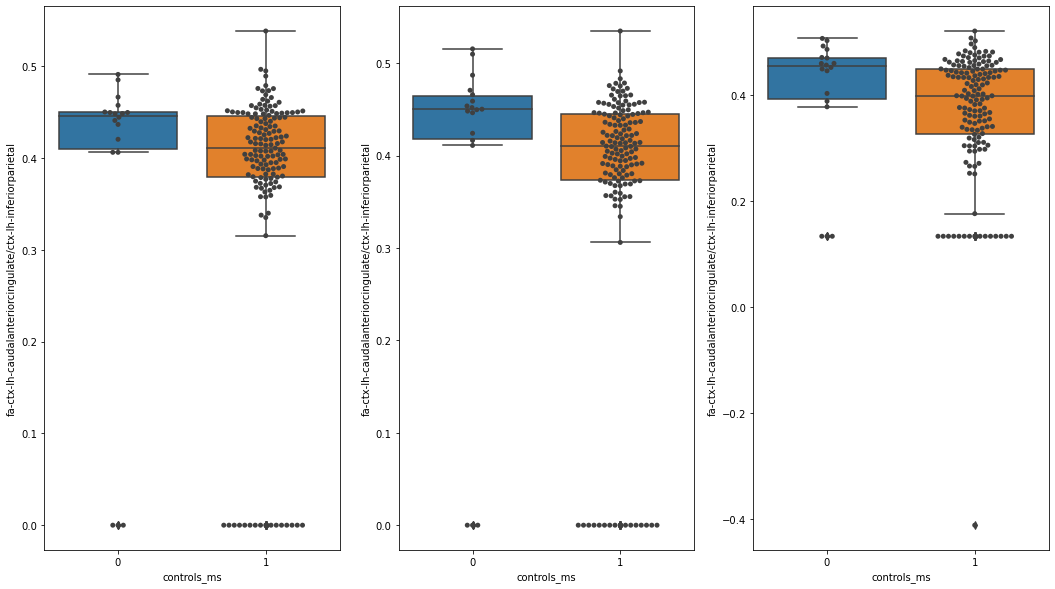

In [60]:
data = [pd.concat([fa_conec, clinical_data], join="inner", axis=1), fa_correct, fa_har]

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

for i in range(3):
    sns.boxplot(ax=axes[i],
                y=fa_conec.columns[1], 
                x='controls_ms', 
                data=data[i])

    sns.swarmplot(ax = axes[i],
                  y=fa_conec.columns[1], 
                  x='controls_ms', 
                  data=data[i], 
                  color=".25")

### *3.2. Imputation*

In [61]:
from sklearn.linear_model import LinearRegression

def outlier_imputation(neuro_data):
    """
    Deals with the problem of zero-values in data by using linear regression models for imputation.

    Arguments:
    ----------

    neuro_data: data that have to be corrected. Important, do not include Clinical Data.

    Returns:
    --------

    pandas dataframe with the corrected data.
    """
    columns = [col for col in neuro_data.columns]
    df = neuro_data.copy()
    
    model = LinearRegression()

    for col in columns:
        if df[df[col] == 0].shape[0] != 0:
            X_train, y_train = df[df[col] != 0].drop([col], axis = 1), df[df[col] != 0][col]
            X_test = df[df[col] == 0].drop([col], axis = 1)

            model = LinearRegression()
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            df.loc[X_test.index, col] = pred
    return df

In [62]:
# Clinical Data

clinical_data = fa.iloc[:, -5:]

# Connectivity test
index = connectivity_test(fa.iloc[:, :-5], clinical_data)

fa_conec = fa.iloc[:, index]

# age and sex corrections
fa_correct = linear_correction(clinical_data, fa_conec)
fa_imputed = outlier_imputation(fa_correct.iloc[:, :-5])

# harmonization
fa_har = harmonization(fa_imputed, clinical_data)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [63]:
fa_correct

,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-caudalmiddlefrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-inferiorparietal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-isthmuscingulate,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-lateralorbitofrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-medialorbitofrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-middletemporal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-paracentral,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-parsopercularis,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-parsorbitalis,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-parstriangularis,...,fa-ctx-rh-superiortemporal/ctx-rh-transversetemporal,fa-ctx-rh-superiortemporal/ctx-rh-insula,fa-ctx-rh-supramarginal/ctx-rh-transversetemporal,fa-ctx-rh-supramarginal/ctx-rh-insula,fa-ctx-rh-transversetemporal/ctx-rh-insula,age,sex,dd,edss,controls_ms
002MSVIS,0.401281,0.375880,0.493108,0.360572,0.348160,0.389351,0.332114,0.349945,0.291961,0.321164,...,0.331984,0.384339,0.359255,0.353211,0.349225,51.53,1,22.18,7.5,1
003MSVIS,0.338079,0.345057,0.457120,0.341322,0.359009,0.338479,0.327782,0.334441,0.000000,0.331603,...,0.306799,0.360030,0.332175,0.331107,0.343456,58.06,0,9.57,6.0,1
004MSVIS,0.430768,0.391692,0.495012,0.383830,0.368945,0.391198,0.373513,0.406220,0.000000,0.398808,...,0.300302,0.364515,0.366287,0.371159,0.355987,60.78,1,6.79,3.0,1
005MSVIS,0.372430,0.404037,0.477372,0.309504,0.330831,0.442829,0.403254,0.391089,0.000000,0.364499,...,0.331597,0.394785,0.424393,0.400668,0.375016,37.95,0,8.45,1.5,1
010MSVIS,0.358555,0.383825,0.451884,0.357345,0.352748,0.377744,0.365136,0.366170,0.381761,0.350057,...,0.277040,0.336902,0.354331,0.351019,0.345598,52.64,0,9.05,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sFIS_04,0.430788,0.450175,0.515509,0.449645,0.424000,0.000000,0.420407,0.406309,0.384843,0.394141,...,0.332517,0.369312,0.335621,0.394486,0.331953,32.98,1,-1.00,0.0,0
sFIS_05,0.436726,0.509721,0.509667,0.457909,0.442735,0.000000,0.409901,0.440541,0.000000,0.411800,...,0.363557,0.397600,0.415235,0.405084,0.384904,23.76,0,-1.00,0.0,0
sFIS_06,0.428366,0.000000,0.537060,0.490742,0.424838,0.000000,0.422603,0.442999,0.468241,0.445795,...,0.408032,0.409463,0.433186,0.419804,0.403460,24.11,0,-1.00,0.0,0
sFIS_07,0.470477,0.515442,0.538171,0.000000,0.394718,0.000000,0.415694,0.436903,0.000000,0.405918,...,0.382070,0.406766,0.374059,0.397587,0.354572,23.98,0,-1.00,0.0,0


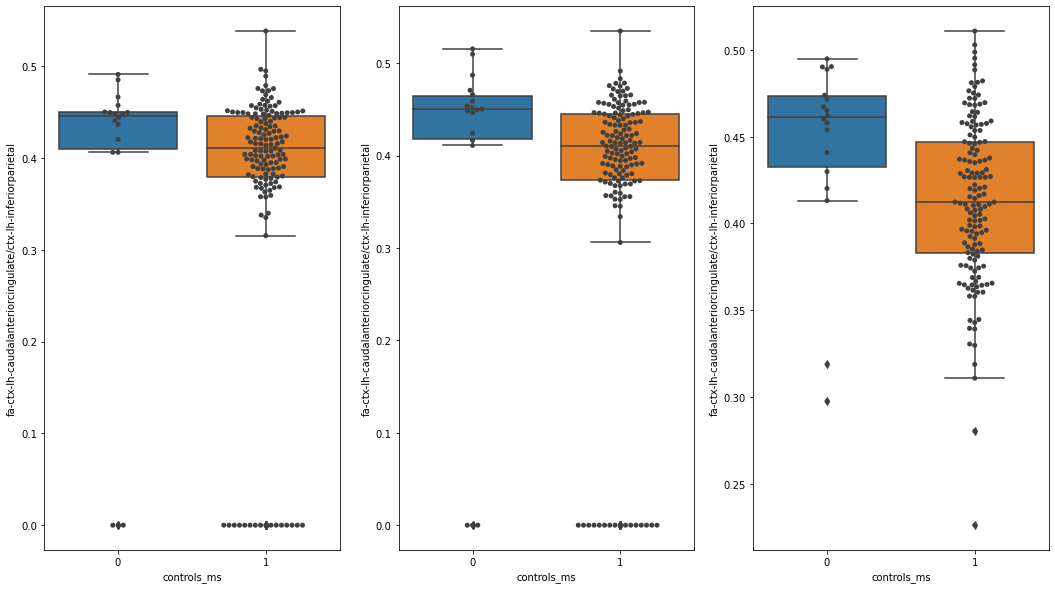

In [64]:
data = [pd.concat([fa_conec, clinical_data], join="inner", axis=1), fa_correct, fa_har]

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

for i in range(3):
    sns.boxplot(ax=axes[i],
                y=fa_conec.columns[1], 
                x='controls_ms', 
                data=data[i])

    sns.swarmplot(ax = axes[i],
                  y=fa_conec.columns[1], 
                  x='controls_ms', 
                  data=data[i], 
                  color=".25")

#### Kamila: Performing t-tests on corrected values

In [65]:
# fa_har.to_csv("dataframes_csv\\fa_har.csv")
# fa_correct.to_csv("dataframes_csv\\fa_correct.csv")

In [66]:
fa_har.head()

,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-caudalmiddlefrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-inferiorparietal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-isthmuscingulate,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-lateralorbitofrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-medialorbitofrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-middletemporal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-paracentral,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-parsopercularis,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-parsorbitalis,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-parstriangularis,...,fa-ctx-rh-superiortemporal/ctx-rh-transversetemporal,fa-ctx-rh-superiortemporal/ctx-rh-insula,fa-ctx-rh-supramarginal/ctx-rh-transversetemporal,fa-ctx-rh-supramarginal/ctx-rh-insula,fa-ctx-rh-transversetemporal/ctx-rh-insula,age,sex,dd,edss,controls_ms
002MSVIS,0.405856,0.368830,0.504165,0.362716,0.361496,0.372652,0.340068,0.352431,0.275610,0.320884,...,0.349696,0.391825,0.368423,0.358933,0.358429,51.53,1,22.18,7.5,1
003MSVIS,0.338864,0.329821,0.464051,0.336094,0.374580,0.307407,0.335315,0.335110,0.371653,0.332679,...,0.321412,0.364390,0.337147,0.333899,0.351446,58.06,0,9.57,6.0,1
004MSVIS,0.437113,0.388840,0.506287,0.394878,0.386564,0.375022,0.385488,0.415301,0.412139,0.408613,...,0.314116,0.369450,0.376544,0.379260,0.366615,60.78,1,6.79,3.0,1
005MSVIS,0.375275,0.404464,0.486625,0.292094,0.340597,0.441241,0.418117,0.398397,0.350688,0.369847,...,0.349261,0.403614,0.443653,0.412681,0.389649,37.95,0,8.45,1.5,1
010MSVIS,0.360568,0.378884,0.458215,0.358253,0.367029,0.357765,0.376297,0.370557,0.385039,0.353530,...,0.287991,0.338286,0.362736,0.356450,0.354038,52.64,0,9.05,2.0,1


In [67]:
from scipy.stats import ttest_ind
t_tests = pd.DataFrame(columns=['ROI', 't', 'pvalue'])
patients_fa = fa_har.loc[fa["controls_ms"] == 1]
patients_fa.drop(labels = ["controls_ms", "age", "sex", "dd", "edss"], axis = 1, inplace = True)
controls_fa = fa_har.loc[fa["controls_ms"] == 0]
controls_fa.drop(labels =  ["controls_ms", "age", "sex", "dd", "edss"], axis = 1, inplace = True)
# controls = controls_fa.iloc[:,:-4]
# patients = patients_fa.iloc[:,:-4]
feats = fa_correct.iloc[:, :-5].columns.to_list()
for attr in feats:
    stat,p = ttest_ind(patients_fa[attr], controls_fa[attr])
    #print(attr, ': stat=%.3f, p=%.3f' % (stat, p))
    t_tests = t_tests.append({'ROI': attr, 't': stat, 'pvalue': p}, ignore_index=True)

C:\Users\kamil\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Mann-Whitney U

In [68]:
from scipy.stats import mannwhitneyu
MannWhitney_tests = pd.DataFrame(columns=['ROI', 'U', 'pvalue'])
for attr in feats:
    stat,p = mannwhitneyu(patients_fa[attr], controls_fa[attr])
#     print(attr[0], ': stat=%.3f, p=%.3f' % (stat, p))
    MannWhitney_tests = MannWhitney_tests.append({'ROI': attr, 'U': stat, 'pvalue': p}, ignore_index=True)

In [69]:
from statsmodels.stats.multitest import fdrcorrection
test, p_corr = fdrcorrection(MannWhitney_tests["pvalue"], alpha = 0.05, method = "indep", is_sorted = False)
MannWhitney_tests ["Rejected"] = test
MannWhitney_tests ["p_corr"] = p_corr

print("MannWhitney_tests uncorrected p<.05:", MannWhitney_tests[MannWhitney_tests["pvalue"] < 0.05].count()["U"],"\n",
      "MannWhitney_tests uncorrected p<.01:", MannWhitney_tests[MannWhitney_tests["pvalue"] < 0.01].count()["U"],"\n",
      "MannWhitney_tests corrected p<.05:",MannWhitney_tests[MannWhitney_tests["Rejected"]==True].count()["Rejected"],"\n",
      "MannWhitney_tests corrected p<.01:", MannWhitney_tests[MannWhitney_tests["p_corr"] < 0.01].count()["U"])

MannWhitney_tests uncorrected p<.05: 1277 
 MannWhitney_tests uncorrected p<.01: 937 
 MannWhitney_tests corrected p<.05: 1193 
 MannWhitney_tests corrected p<.01: 792


In [70]:
#correction for multiple comparisons
from statsmodels.stats.multitest import fdrcorrection
test, p_corr = fdrcorrection(t_tests["pvalue"], alpha = 0.05, method = "indep", is_sorted = False)
t_tests ["Rejected"] = test
t_tests ["p_corr"] = p_corr

print("T-tests uncorrected p<.05:", t_tests[t_tests["pvalue"] < 0.05].count()["t"],"\n",
      "T-tests uncorrected p<.01:", t_tests[t_tests["pvalue"] < 0.01].count()["t"],"\n",
      "T-tests corrected p<.05:",t_tests[t_tests["Rejected"]==True].count()["Rejected"],"\n",
      "T-tests corrected p<.01:", t_tests[t_tests["p_corr"] < 0.01].count()["t"])

T-tests uncorrected p<.05: 1055 
 T-tests uncorrected p<.01: 690 
 T-tests corrected p<.05: 880 
 T-tests corrected p<.01: 447


In [71]:
difference_fa = t_tests[t_tests["p_corr"] < 0.01]
different_fa = difference_fa["ROI"].tolist()
fa_har_clinical = fa_har.loc[:,["age", "sex", "dd", "edss", "controls_ms"]]
fa_har_t = fa_har[different_fa]
fa_har_new = pd.merge(fa_har_t, fa_har_clinical, left_index=True, right_index=True)

In [72]:
fa_har_new.head()

,fa-ctx-lh-caudalanteriorcingulate/Right-Caudate,fa-ctx-lh-caudalanteriorcingulate/ctx-rh-caudalmiddlefrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-rh-parsopercularis,fa-ctx-lh-caudalanteriorcingulate/ctx-rh-precentral,fa-ctx-lh-caudalanteriorcingulate/ctx-rh-rostralmiddlefrontal,fa-ctx-lh-caudalmiddlefrontal/ctx-lh-paracentral,fa-ctx-lh-caudalmiddlefrontal/ctx-lh-precuneus,fa-ctx-lh-caudalmiddlefrontal/ctx-lh-superiorparietal,fa-ctx-lh-caudalmiddlefrontal/ctx-rh-paracentral,fa-ctx-lh-cuneus/ctx-lh-fusiform,...,fa-ctx-rh-precuneus/ctx-rh-supramarginal,fa-ctx-rh-superiorfrontal/ctx-rh-superiorparietal,fa-ctx-rh-superiorparietal/ctx-rh-superiortemporal,fa-ctx-rh-superiorparietal/ctx-rh-supramarginal,fa-ctx-rh-superiorparietal/ctx-rh-insula,age,sex,dd,edss,controls_ms
002MSVIS,0.408191,0.457816,0.439021,0.447803,0.409330,0.402513,0.419906,0.412493,0.475932,0.355825,...,0.385528,0.443427,0.400021,0.364232,0.423372,51.53,1,22.18,7.5,1
003MSVIS,0.342879,0.407028,0.388571,0.385901,0.385077,0.375369,0.387212,0.390119,0.415534,0.365282,...,0.348375,0.372116,0.388428,0.351301,0.388275,58.06,0,9.57,6.0,1
004MSVIS,0.463562,0.510007,0.475843,0.501402,0.487431,0.437282,0.427043,0.418921,0.510079,0.418228,...,0.423645,0.441639,0.433578,0.415820,0.428551,60.78,1,6.79,3.0,1
005MSVIS,0.382274,0.446907,0.443453,0.442232,0.415597,0.424615,0.423734,0.425994,0.504077,0.391691,...,0.405273,0.450531,0.437811,0.397737,0.421525,37.95,0,8.45,1.5,1
010MSVIS,0.398361,0.430988,0.417371,0.426543,0.420971,0.384328,0.409058,0.407761,0.411752,0.384797,...,0.370932,0.401597,0.402065,0.374731,0.414996,52.64,0,9.05,2.0,1


## **4. Dimensionality Reduction**

### *4.1. Evaluation Metric: Logistic Regression*

Before going through different dimensionality reduction techniques, it's important to establish a general metric to have a starting point on which to base ourselves when evaluating the effectiveness of the applied techniques.

First of all, let's switch the target (*controls_ms*) for bla bla bla

In [73]:
# controls_list = [0 if num == 1 else 1 for num in fa_har.iloc[:, -1]]
# fa_har.iloc[:, -1] = controls_list
# fa_har.iloc[:, -1].describe()

In [74]:
controls_list = [0 if num == 1 else 1 for num in fa_har_new.iloc[:, -1]]
fa_har_new.iloc[:, -1] = controls_list
fa_har_new.iloc[:, -1].describe()

count    165.000000
mean       0.109091
std        0.312702
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: controls_ms, dtype: float64

In [75]:
def evaluation(X, y):
    logistic_model = LogisticRegression(max_iter=450)
    scores = cross_val_score(logistic_model, X, y, cv=5, scoring="f1")
    print(scores.mean())

evaluation(fa_har_new.iloc[:, :-5], fa_har_new.iloc[:, -1])

0.0


In [76]:
sc = StandardScaler()
target = fa_har_new.iloc[:, -1]
standarized_fa = sc.fit_transform(fa_har_new.iloc[:, :-5])
standarized_fa = pd.DataFrame(standarized_fa, index=fa_har_new.iloc[:, :-5].index, columns=fa_har_new.iloc[:, :-5].columns)

evaluation(standarized_fa, target)

0.263030303030303


### **4.2. FA Data**

**4.2.1. PCA Feature Extraction**

Text(0, 0.5, 'Cumulative Variability')

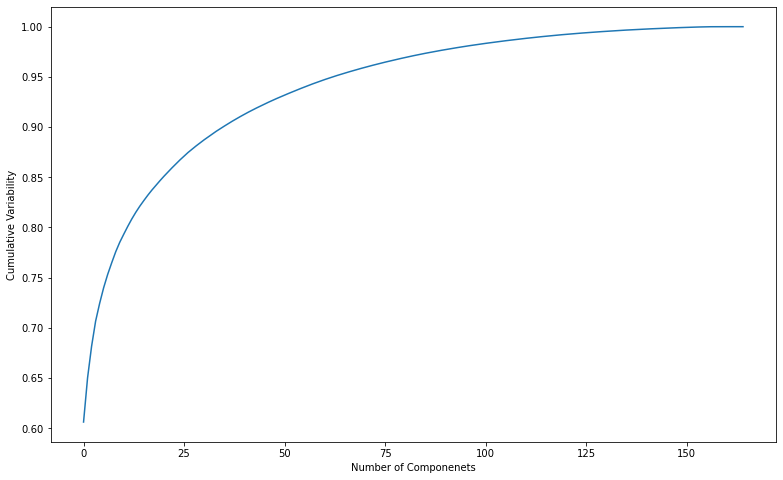

In [77]:
pca = PCA().fit(standarized_fa)

plt.figure(figsize=(13, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Componenets")
plt.ylabel("Cumulative Variability")

In [78]:
pca = PCA(n_components=0.9)
fa_pca = pca.fit_transform(standarized_fa)

column_names = ["PCA " + str(i) for i in range(fa_pca.shape[1])]
fa_pca = pd.DataFrame(fa_pca, columns = column_names, index = fa.index)
fa_pca

,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9,...,PCA 26,PCA 27,PCA 28,PCA 29,PCA 30,PCA 31,PCA 32,PCA 33,PCA 34,PCA 35
002MSVIS,4.292257,7.216351,5.015392,-5.291725,4.554198,2.749019,-0.261833,1.492854,4.278344,0.703182,...,-0.893176,0.429144,0.591505,-0.281065,-0.603425,0.461344,0.413053,0.202811,-0.034483,-0.773880
003MSVIS,19.014678,-10.196440,0.603374,-5.255334,-0.824434,-0.167952,0.502468,0.119803,2.833016,-1.642069,...,-1.060034,-1.835893,0.220403,-0.027489,-0.930102,-0.178777,0.797145,-0.190315,-1.014932,0.427716
004MSVIS,-8.543223,-2.043667,0.789362,-3.277932,-1.364275,-1.858096,-1.102426,1.622353,-5.214334,3.000756,...,1.702668,-0.380914,1.229646,0.488032,-0.668935,-0.056812,0.521821,0.289723,-0.536429,-1.200652
005MSVIS,-4.317435,1.217485,3.839914,-2.985050,0.304660,-1.721976,3.222035,-0.671436,-1.947560,-3.711790,...,-1.541548,1.797461,-0.168638,1.267035,-0.995275,0.155601,-0.754588,1.107946,-0.082017,-1.554060
010MSVIS,14.676672,-2.665659,2.279895,2.252917,-0.942314,1.834768,-3.398591,3.912098,-3.143328,-0.025345,...,0.806238,0.638490,-0.746228,-0.381327,-0.285522,0.184564,-0.258469,2.519673,0.046724,0.702799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sFIS_04,-13.839377,-1.901950,-0.110523,-3.246830,2.835630,-0.669910,-0.519005,-2.545829,-0.201724,-2.942011,...,-0.050732,-2.586383,1.019866,1.645781,0.611749,-0.997519,1.366398,0.517496,-0.084012,0.009373
sFIS_05,-17.873219,-2.625139,-0.755583,2.894216,0.951456,-0.403951,-2.790883,-1.554398,-0.779417,-1.178104,...,0.172632,-0.718960,-0.795005,0.268193,-0.561033,2.308134,0.976174,-0.847235,-1.224533,-0.596022
sFIS_06,-28.893601,2.617809,-1.736555,4.109544,1.320476,0.854802,0.062386,-0.971382,-2.207578,-1.498800,...,-0.655393,1.006221,-2.329507,-0.786784,-1.359068,-0.585563,0.945435,-0.959237,0.184780,-1.070776
sFIS_07,-10.443817,1.305394,-1.861839,0.770010,-0.698523,0.641909,0.282896,0.288068,0.462614,1.480629,...,-0.200870,-0.203677,1.922167,2.011787,-1.173170,2.415176,1.392867,0.986579,-1.308585,-0.432417


In [79]:
variable_list = list()

num = pca.explained_variance_ratio_.sum()/100

for i in range(len(pca.components_)):
    aux = int(pca.explained_variance_ratio_[i] / num)
    if aux == 0:
        aux = 1
    test_df = pd.DataFrame(abs(pca.components_)[i])
    aux_list = test_df[0].sort_values(ascending=False).index[:aux]
    variable_list.append([num for num in aux_list])

final_list = list()
for i in range(len(variable_list)): # Només n'he possat 1
    for j in range(len(variable_list[i])):
        if variable_list[i][j] not in final_list:
            final_list.append(variable_list[i][j])

pca_columns = [name for name in fa.iloc[:, final_list].columns]
pca_df = fa.iloc[:, final_list[:25]]

In [80]:
evaluation(standarized_fa.iloc[:, final_list[:36]], target)

0.16


**4.2.2. Feature Importance with Random Forest**

The feature importance in random forest is computed by using the *gini importance*

**Gini importance** (or mean decrease impurity), which is computed from the Random Forest structure. Let’s look how the Random Forest is constructed. It is a set of Decision Trees. Each Decision Tree is a set of internal nodes and leaves. In the internal node, the selected feature is used to make decision how to divide the data set into two separate sets with similars responses within. The features for internal nodes are selected with some criterion, which for classification tasks can be gini impurity or infomation gain, and for regression is variance reduction. We can measure how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance. This method is available in scikit-learn implementation of the Random Forest (for both classifier and regressor). It is worth to mention, that in this method we should look at relative values of the computed importances. This biggest advantage of this method is a speed of computation - all needed values are computed during the Radom Forest training. The drawbacks of the method is to tendency to prefer (select as important) numerical features and categorical features with high cardinality. **What is more, in the case of correlated features it can select one of the feature and neglect the importance of the second one (which can lead to wrong conclusions).**

In [81]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=2)
rf.fit(standarized_fa, target)

RandomForestClassifier(max_depth=2, n_estimators=1000)

[Text(0, 0.5, 'Attributes'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0.5, 1.0, 'Sorted Feature Importance')]

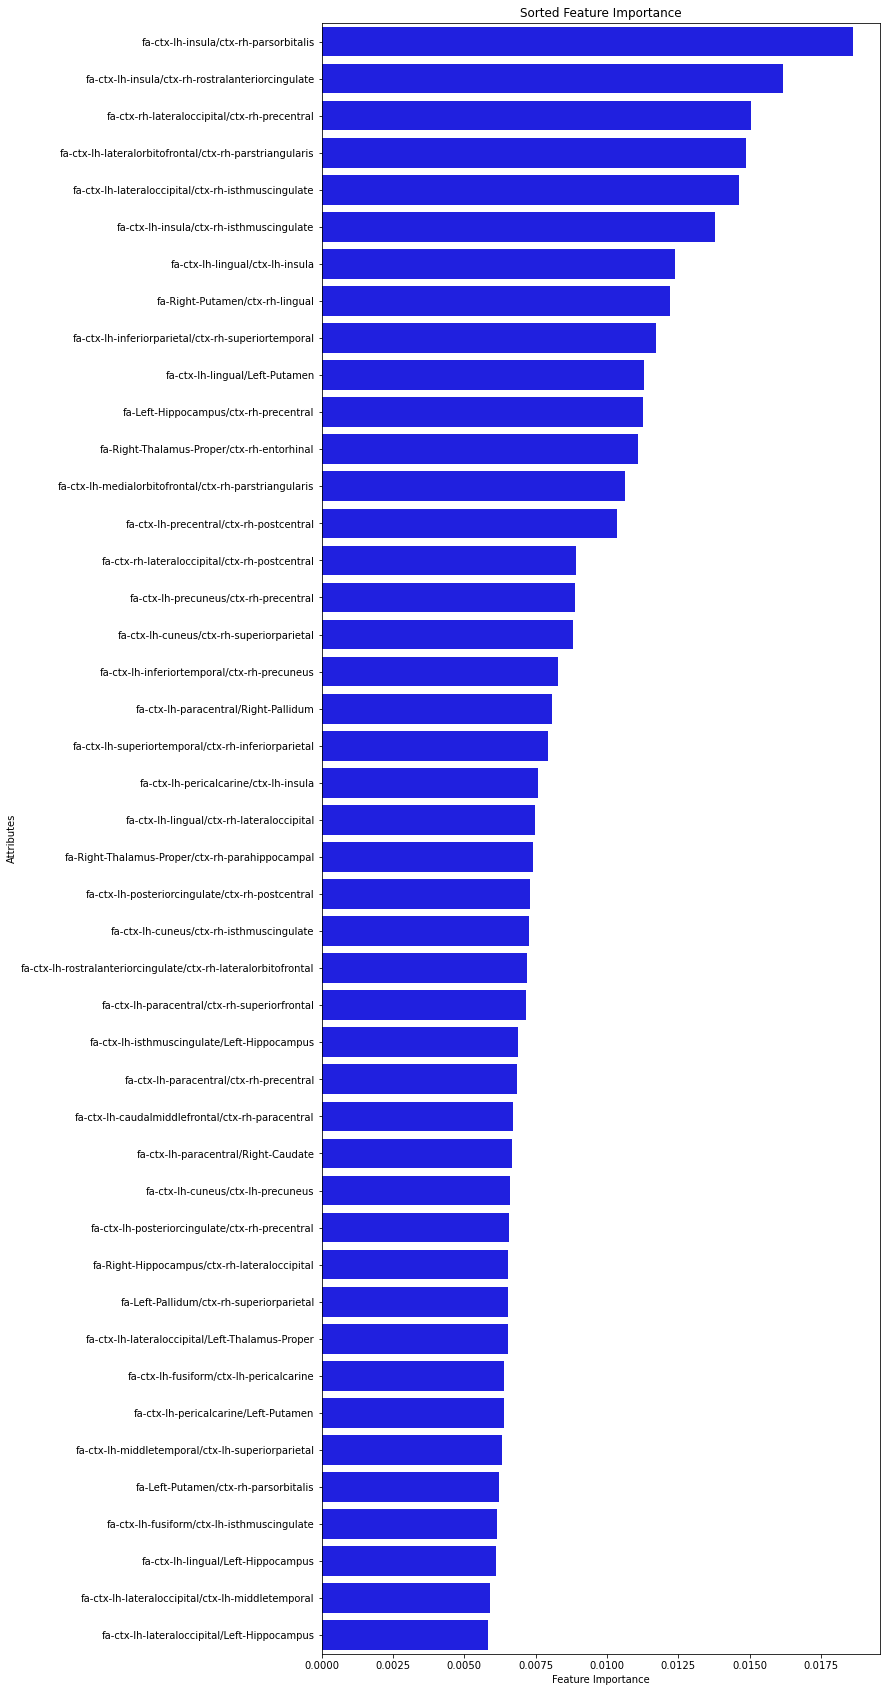

In [82]:
# Feature importance
f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(standarized_fa.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

# Visualizing it in a horizontal bar plot
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# Plot
sns.barplot(x='Feature Importance', y=importance_sorted.index,data = importance_sorted,color="b")
ax.set(title= "Sorted Feature Importance",ylabel="Attributes",xlabel="Feature Importance")

Once we have selected the first fifty most important features, let's evaluate the efectivity of the model using them.

In [83]:
rf_columns = [col for col in importance_sorted.index]

evaluation(standarized_fa.loc[:, rf_columns[:27]], target) # 27 is optimal but with 3 we obtain 43% 

0.46190476190476193


In [84]:
rf_columns[0:3]

['fa-ctx-lh-insula/ctx-rh-parsorbitalis',
 'fa-ctx-lh-insula/ctx-rh-rostralanteriorcingulate',
 'fa-ctx-rh-lateraloccipital/ctx-rh-precentral']

Finally, let's visualizate the first nine features in terms of feature importance.

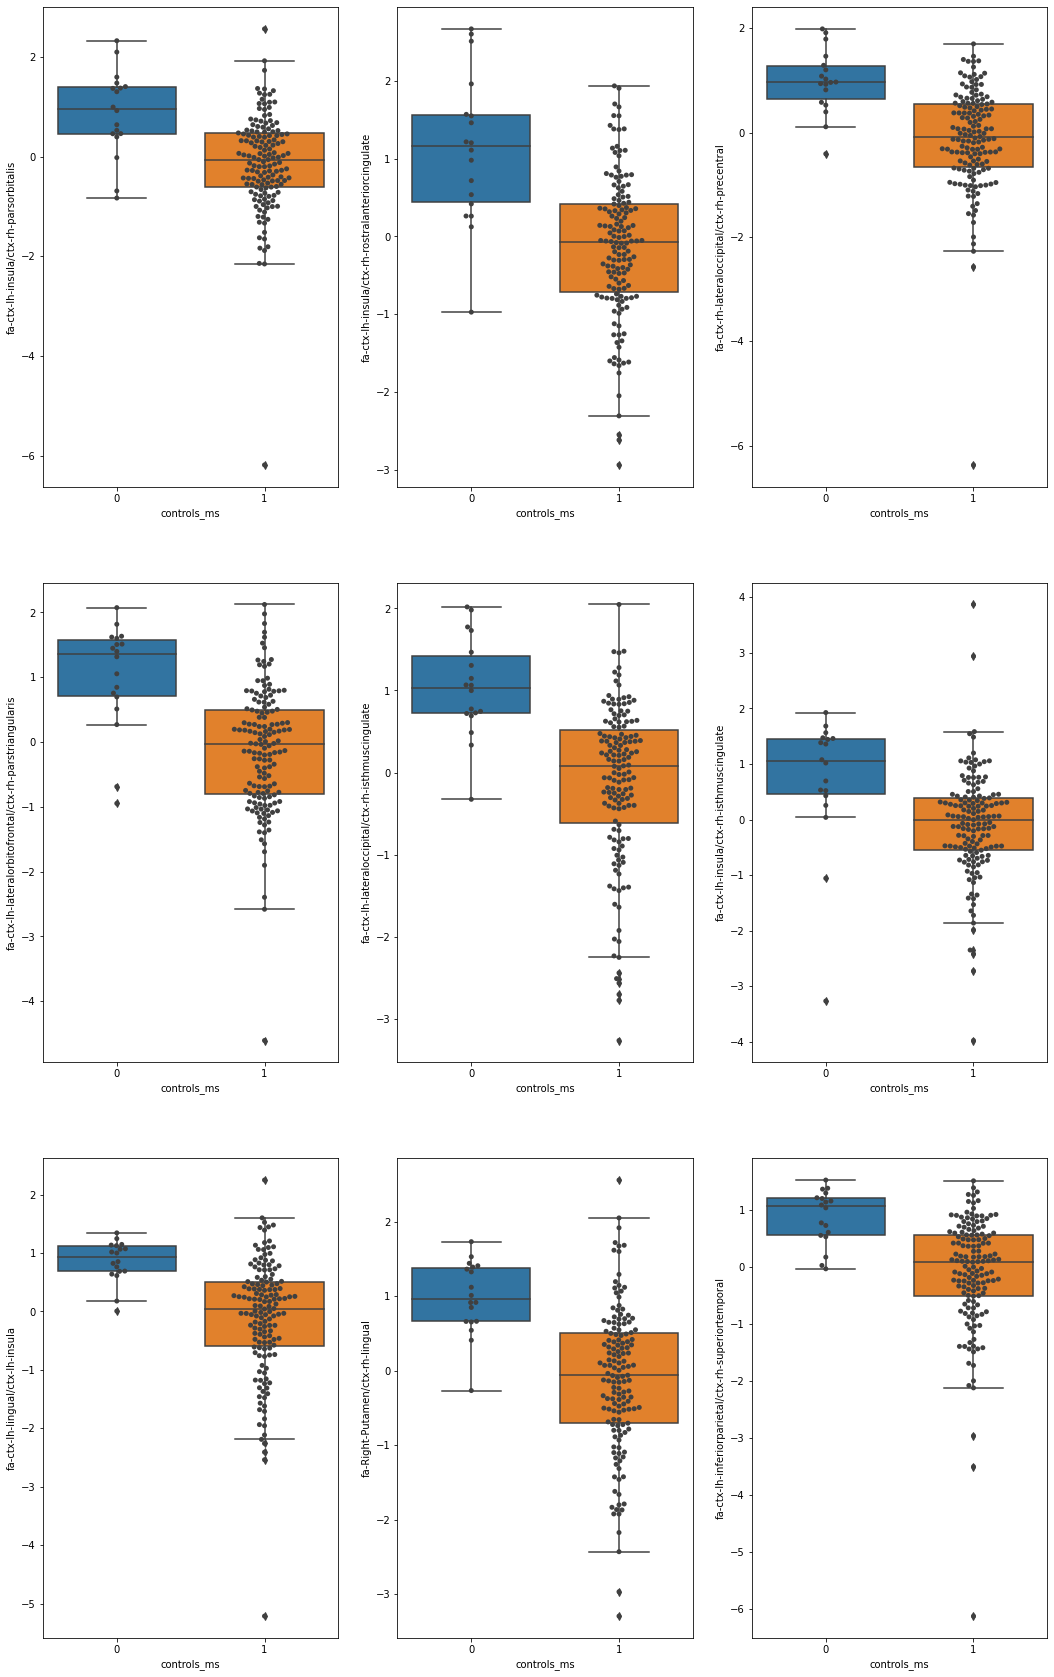

In [85]:
ploting = pd.concat([standarized_fa, fa.iloc[:, -1]], axis=1, join="inner")

fig, axes = plt.subplots(3, 3, figsize=(18, 30))

for i in range(3):
    for j in range(3):
        sns.boxplot(ax=axes[i, j],
                    y=rf_columns[(i*3)+j], 
                    x='controls_ms', 
                    data=ploting)

        sns.swarmplot(ax = axes[i, j],
                     y=rf_columns[(i*3)+j], 
                     x='controls_ms', 
                     data=ploting, 
                     color=".25")

**4.2.3. Clustering**

In [86]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=20, random_state=42)),
    ("log", LogisticRegression(max_iter=1000)),
])

X_train, X_valid, y_train, y_valid = train_test_split(standarized_fa, target, test_size = 0.2, random_state = 42)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=20, random_state=42)),
                ('log', LogisticRegression(max_iter=1000))])

In [87]:
pred = pipeline.predict(X_valid)

In [88]:
f1_score(pred, y_valid)

0.5714285714285715

### 4.3. GM Networks Data

**4.3.1. Zero Problem Visualization**

C:\Users\kamil\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\kamil\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\kamil\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\kamil\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 29.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\kamil\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 14.3% of the points

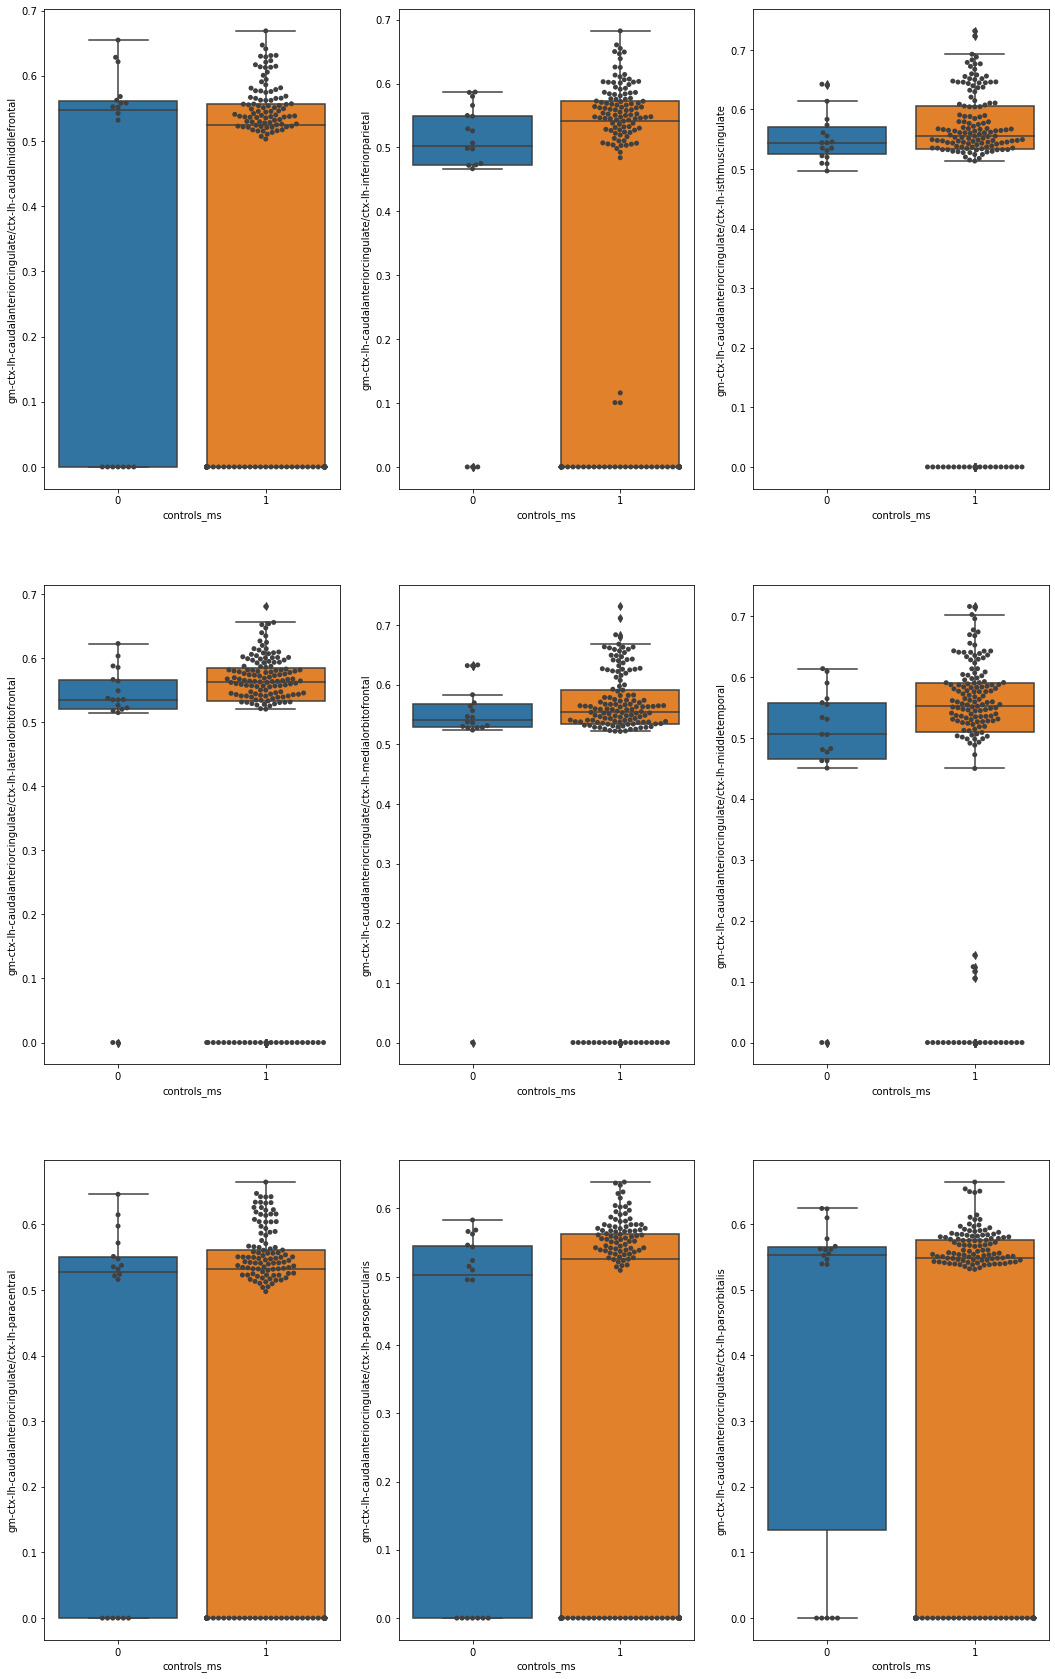

In [89]:
fig, axes = plt.subplots(3, 3, figsize=(18, 30))

for i in range(3):
    for j in range(3):
        sns.boxplot(ax=axes[i, j],
                    y=gm_correct.columns[(i*3)+j], 
                    x='controls_ms', 
                    data=gm_correct)

        sns.swarmplot(ax = axes[i, j],
                     y=gm_correct.columns[(i*3)+j], 
                     x='controls_ms', 
                     data=gm_correct, 
                     color=".25")

**4.3.2. Imputation and reference evaluation**

In [90]:
gm_imputed = outlier_imputation(gm_correct.iloc[:, :-5])
gm_imputed

,gm-ctx-lh-caudalanteriorcingulate/ctx-lh-caudalmiddlefrontal,gm-ctx-lh-caudalanteriorcingulate/ctx-lh-inferiorparietal,gm-ctx-lh-caudalanteriorcingulate/ctx-lh-isthmuscingulate,gm-ctx-lh-caudalanteriorcingulate/ctx-lh-lateralorbitofrontal,gm-ctx-lh-caudalanteriorcingulate/ctx-lh-medialorbitofrontal,gm-ctx-lh-caudalanteriorcingulate/ctx-lh-middletemporal,gm-ctx-lh-caudalanteriorcingulate/ctx-lh-paracentral,gm-ctx-lh-caudalanteriorcingulate/ctx-lh-parsopercularis,gm-ctx-lh-caudalanteriorcingulate/ctx-lh-parsorbitalis,gm-ctx-lh-caudalanteriorcingulate/ctx-lh-parstriangularis,...,gm-ctx-rh-superiorparietal/ctx-rh-superiortemporal,gm-ctx-rh-superiorparietal/ctx-rh-supramarginal,gm-ctx-rh-superiorparietal/ctx-rh-transversetemporal,gm-ctx-rh-superiorparietal/ctx-rh-insula,gm-ctx-rh-superiortemporal/ctx-rh-supramarginal,gm-ctx-rh-superiortemporal/ctx-rh-transversetemporal,gm-ctx-rh-superiortemporal/ctx-rh-insula,gm-ctx-rh-supramarginal/ctx-rh-transversetemporal,gm-ctx-rh-supramarginal/ctx-rh-insula,gm-ctx-rh-transversetemporal/ctx-rh-insula
002MSVIS,0.385247,0.369048,0.179126,0.389113,0.161146,0.264958,0.327448,0.406316,0.440465,0.454983,...,0.547346,0.508387,0.530204,0.464761,0.111195,0.531376,0.127920,0.478243,0.317639,0.505365
003MSVIS,0.525921,0.200500,0.363229,0.406143,0.359217,0.198296,0.355875,0.340870,0.505985,0.371055,...,0.481110,0.455937,0.533585,0.484028,0.340518,0.470192,0.404125,0.458167,0.508440,0.540848
004MSVIS,0.509088,0.503015,0.273393,0.593249,0.624953,0.105239,0.452249,0.456850,0.568040,0.478341,...,0.489386,0.443792,0.559301,0.320096,0.157021,0.562804,0.151116,0.517939,0.113186,0.529325
005MSVIS,0.535536,0.395316,0.543390,0.576287,0.522394,0.492852,0.530641,0.479232,0.542229,0.531759,...,0.497080,0.463831,0.533686,0.504449,0.456757,0.531989,0.476864,0.506386,0.525690,0.532811
010MSVIS,0.524709,0.562057,0.560750,0.560077,0.537612,0.554074,0.544895,0.562187,0.531680,0.558477,...,0.532126,0.517681,0.531928,0.502645,0.541064,0.559189,0.520182,0.542368,0.528138,0.535962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sFIS_04,0.621450,0.579890,0.613776,0.587572,0.631700,0.590037,0.597229,0.583180,0.609307,0.556294,...,0.590592,0.580830,0.542190,0.623354,0.580845,0.524506,0.642722,0.564416,0.593488,0.591198
sFIS_05,0.568119,0.497642,0.496803,0.534644,0.528079,0.482524,0.553194,0.509884,0.577378,0.521815,...,0.487875,0.479911,0.531923,0.496986,0.407717,0.527648,0.452290,0.505119,0.458200,0.533775
sFIS_06,0.558050,0.472002,0.509705,0.517480,0.531197,0.462430,0.497346,0.495616,0.538425,0.540975,...,0.475967,0.475240,0.532784,0.494356,0.416070,0.520064,0.456137,0.498327,0.471763,0.532508
sFIS_07,0.472286,0.472723,0.535068,0.522196,0.523816,0.450457,0.520826,0.495202,0.561924,0.504854,...,0.473908,0.466453,0.539148,0.496760,0.413996,0.519857,0.477961,0.491980,0.474905,0.537429


In [91]:
gm_clinical = gm_correct.iloc[:,-5:]
gm_clinical.head(2)

,age,sex,dd,edss,controls_ms
002MSVIS,51.53,1,22.18,7.5,1
003MSVIS,58.06,0,9.57,6.0,1


In [92]:
from scipy.stats import ttest_ind
gm_t_tests = pd.DataFrame(columns=['ROI', 't', 'pvalue'])
gm_imputed_new = pd.merge(gm_imputed, gm_clinical, left_index=True, right_index=True)
patients_gm = gm_imputed_new.loc[fa["controls_ms"] == 1]
controls_gm = gm_imputed_new.loc[fa["controls_ms"] == 0]
feats = gm_imputed.columns.to_list()
for attr in feats:
    stat,p = ttest_ind(patients_gm[attr], controls_gm[attr])
    #print(attr, ': stat=%.3f, p=%.3f' % (stat, p))
    gm_t_tests = gm_t_tests.append({'ROI': attr, 't': stat, 'pvalue': p}, ignore_index=True)

In [93]:
#correction for multiple comparisons
from statsmodels.stats.multitest import fdrcorrection
test, p_corr = fdrcorrection(gm_t_tests["pvalue"], alpha = 0.05, method = "indep", is_sorted = False)
gm_t_tests ["Rejected"] = test
gm_t_tests ["p_corr"] = p_corr

print("T-tests uncorrected p<.05:", gm_t_tests[gm_t_tests["pvalue"] < 0.05].count()["t"],"\n",
      "T-tests uncorrected p<.01:", gm_t_tests[gm_t_tests["pvalue"] < 0.01].count()["t"],"\n",
      "T-tests corrected p<.05:",gm_t_tests[gm_t_tests["Rejected"]==True].count()["Rejected"],"\n",
      "T-tests corrected p<.01:", gm_t_tests[gm_t_tests["p_corr"] < 0.01].count()["t"])

T-tests uncorrected p<.05: 55 
 T-tests uncorrected p<.01: 8 
 T-tests corrected p<.05: 0 
 T-tests corrected p<.01: 0


In [94]:
controls_list = [0 if num == 1 else 1 for num in fa.iloc[:, -1]]
gm.iloc[:, -1] = controls_list
target = gm.iloc[:, -1]
standarized_gm = sc.fit_transform(gm_imputed)
standarized_gm = pd.DataFrame(standarized_gm, index=gm_imputed.index, columns=gm_imputed.columns)

evaluation(standarized_gm, target)

0.03636363636363636


**4.3.3. Random Forest Feature Importance**

[Text(0, 0.5, 'Attributes'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0.5, 1.0, 'Sorted Feature Importance')]

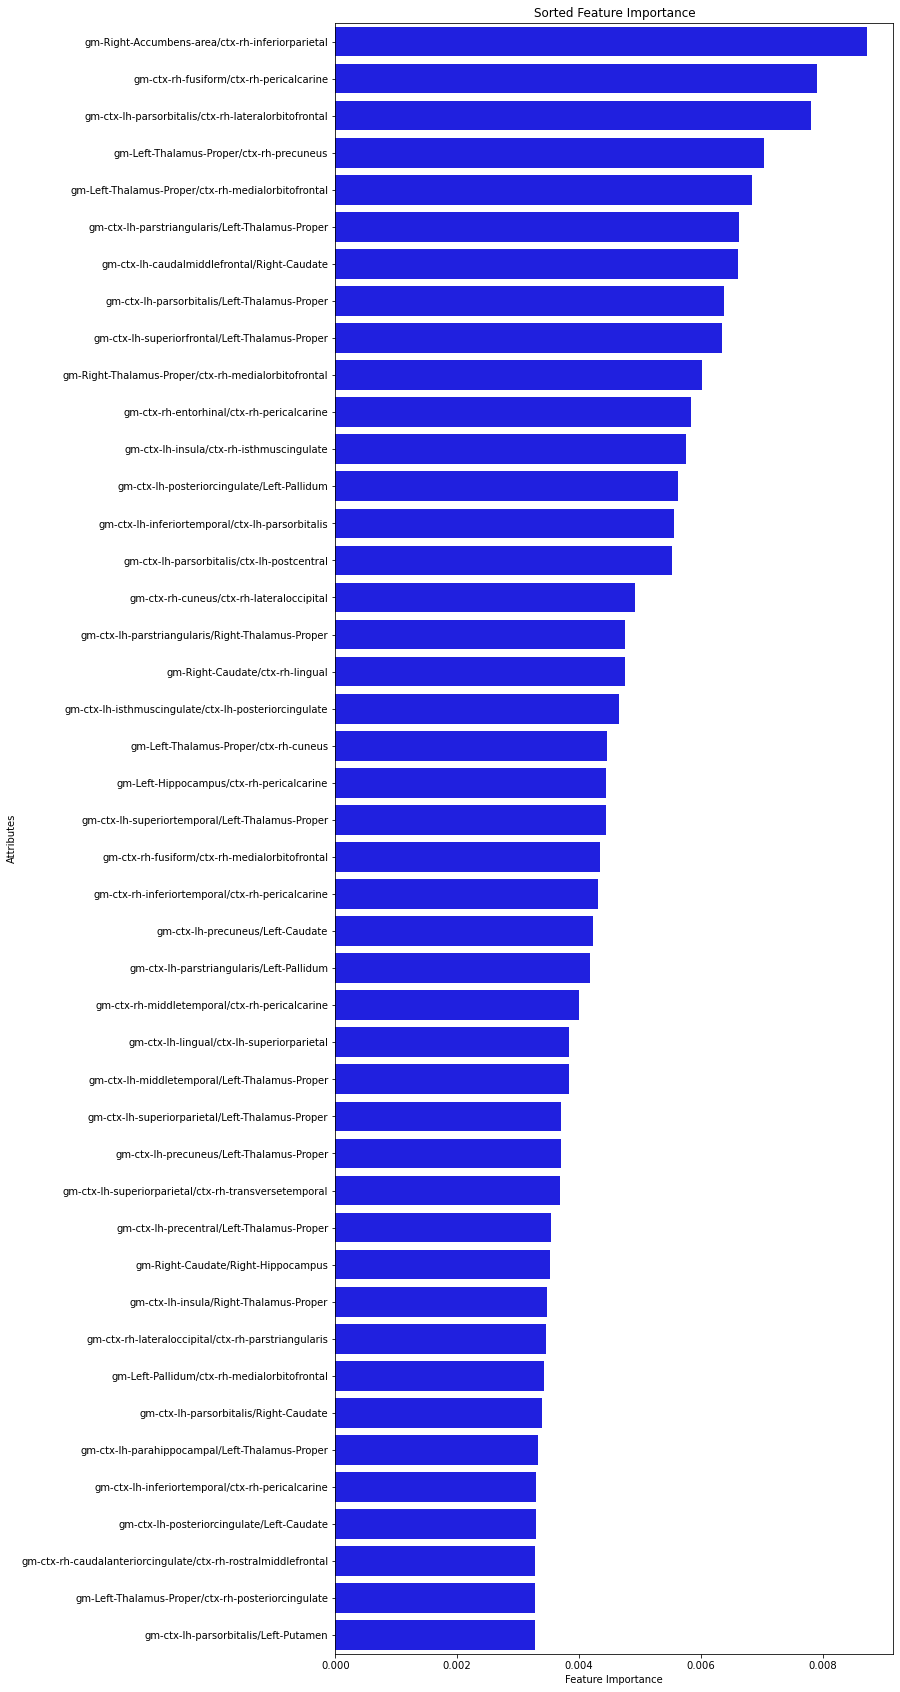

In [95]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=2)
rf.fit(standarized_gm, target)

# Feature importance
f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(standarized_gm.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

# Visualizing it in a horizontal bar plot
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# Plot
sns.barplot(x='Feature Importance', y=importance_sorted.index,data = importance_sorted,color="b")
ax.set(title= "Sorted Feature Importance",ylabel="Attributes",xlabel="Feature Importance")

In [96]:
rf_columns = [col for col in importance_sorted.index]

evaluation(standarized_gm.loc[:, rf_columns[:22]], target) # 13, 15

0.28809523809523807


Plot the most important features.

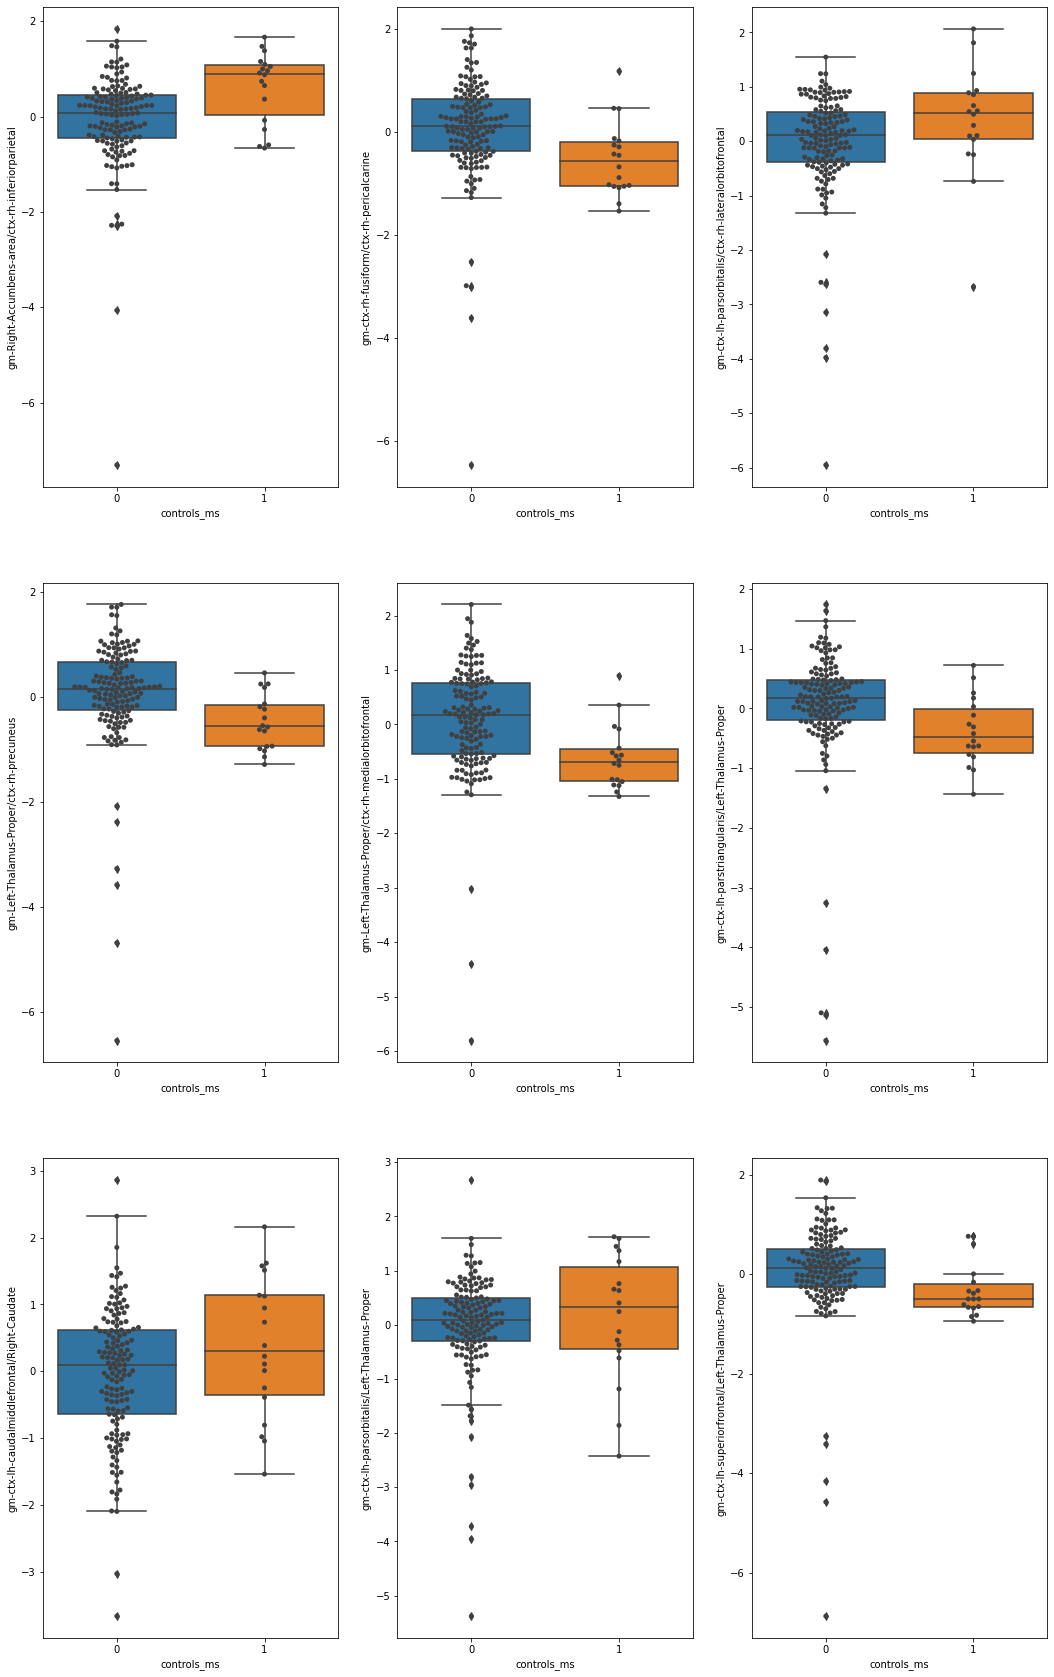

In [97]:
ploting = pd.concat([standarized_gm, gm.iloc[:, -1]], axis=1, join="inner")

fig, axes = plt.subplots(3, 3, figsize=(18, 30))

for i in range(3):
    for j in range(3):
        sns.boxplot(ax=axes[i, j],
                    y=rf_columns[(i*3)+j], 
                    x='controls_ms', 
                    data=ploting)

        sns.swarmplot(ax = axes[i, j],
                     y=rf_columns[(i*3)+j], 
                     x='controls_ms', 
                     data=ploting, 
                     color=".25")

### **4.4. Functional Data**

**4.4.1. Zero Problem Visualization**

C:\Users\kamil\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\kamil\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 21.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\kamil\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 29.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\kamil\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


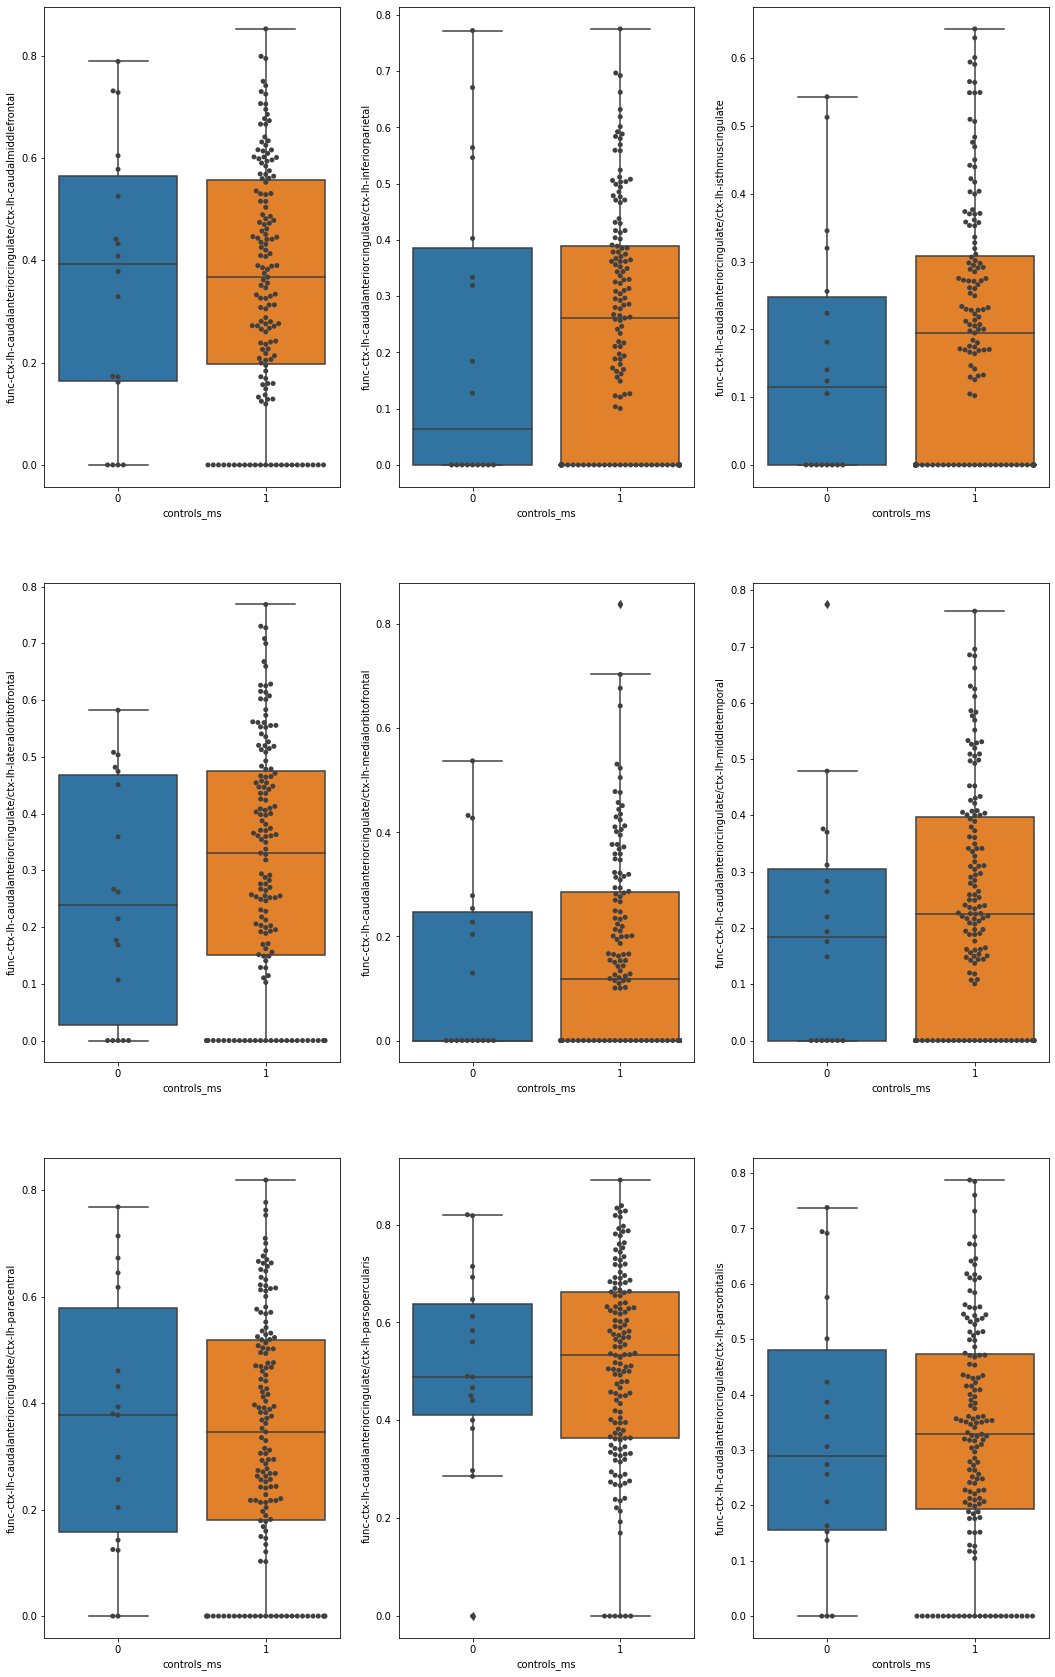

In [98]:
fig, axes = plt.subplots(3, 3, figsize=(18, 30))

for i in range(3):
    for j in range(3):
        sns.boxplot(ax=axes[i, j],
                    y=func_correct.columns[(i*3)+j], 
                    x='controls_ms', 
                    data=func_correct)

        sns.swarmplot(ax = axes[i, j],
                     y=func_correct.columns[(i*3)+j], 
                     x='controls_ms', 
                     data=func_correct, 
                     color=".25")

**4.4.2. Imputation and reference evaluation**

In [99]:
func_imputed = outlier_imputation(func_correct.iloc[:, :-5])
func_imputed

,func-ctx-lh-caudalanteriorcingulate/ctx-lh-caudalmiddlefrontal,func-ctx-lh-caudalanteriorcingulate/ctx-lh-inferiorparietal,func-ctx-lh-caudalanteriorcingulate/ctx-lh-isthmuscingulate,func-ctx-lh-caudalanteriorcingulate/ctx-lh-lateralorbitofrontal,func-ctx-lh-caudalanteriorcingulate/ctx-lh-medialorbitofrontal,func-ctx-lh-caudalanteriorcingulate/ctx-lh-middletemporal,func-ctx-lh-caudalanteriorcingulate/ctx-lh-paracentral,func-ctx-lh-caudalanteriorcingulate/ctx-lh-parsopercularis,func-ctx-lh-caudalanteriorcingulate/ctx-lh-parsorbitalis,func-ctx-lh-caudalanteriorcingulate/ctx-lh-parstriangularis,...,func-ctx-rh-superiorparietal/ctx-rh-superiortemporal,func-ctx-rh-superiorparietal/ctx-rh-supramarginal,func-ctx-rh-superiorparietal/ctx-rh-transversetemporal,func-ctx-rh-superiorparietal/ctx-rh-insula,func-ctx-rh-superiortemporal/ctx-rh-supramarginal,func-ctx-rh-superiortemporal/ctx-rh-transversetemporal,func-ctx-rh-superiortemporal/ctx-rh-insula,func-ctx-rh-supramarginal/ctx-rh-transversetemporal,func-ctx-rh-supramarginal/ctx-rh-insula,func-ctx-rh-transversetemporal/ctx-rh-insula
002MSVIS,0.312720,0.197176,0.279048,0.360808,0.225564,0.212081,0.203852,0.681499,0.319772,0.523703,...,0.384083,0.856254,0.373758,0.515966,0.271454,0.451929,0.458002,0.389448,0.553722,0.543364
003MSVIS,0.389541,0.106157,0.129807,0.251816,0.228033,0.091791,0.177559,0.504170,0.260983,0.205514,...,0.225981,0.702439,0.507863,0.193468,0.382904,0.550983,0.658115,0.486508,0.190640,0.319801
004MSVIS,0.685430,0.258839,0.565578,0.201798,0.194602,0.156118,0.501876,0.833803,0.205435,0.711600,...,0.501722,0.636206,0.205837,0.192348,0.428342,0.477846,0.340299,0.345899,0.488439,0.538084
005MSVIS,0.407455,0.292388,0.146530,0.423611,0.219354,0.341267,0.699948,0.719406,0.583919,0.555510,...,0.434353,0.698039,0.270556,0.352719,0.531579,0.578674,0.799162,0.375101,0.614248,0.697393
010MSVIS,0.124954,0.210101,0.399561,0.237028,0.192904,0.147614,0.242254,0.349283,0.162876,0.195216,...,0.309281,0.688297,0.159306,0.276949,0.484072,0.528432,0.690237,0.300088,0.409823,0.483807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sFIS_04,0.248840,0.193546,0.161048,0.106530,0.223448,0.104944,0.123528,0.383366,0.206095,0.115808,...,0.137579,0.411213,0.051107,0.166674,0.239195,0.542673,0.362059,0.184247,0.284141,0.278697
sFIS_05,0.216376,0.112625,0.107932,0.247945,0.174765,0.129535,0.377344,0.440625,0.152204,0.122113,...,0.280604,0.761569,0.104397,0.408021,0.404911,0.326819,0.459308,0.299470,0.676448,0.634359
sFIS_06,0.731232,0.670918,0.345509,0.474302,0.227629,0.282764,0.082011,0.714569,0.136677,0.279458,...,0.407732,0.514433,0.201810,0.288059,0.439187,0.142951,0.287662,0.169989,0.163634,0.543691
sFIS_07,0.378055,0.333592,0.252515,0.314461,0.155937,0.121833,0.617281,0.285714,0.213534,0.118381,...,0.204810,0.601012,0.100654,0.296860,0.125524,0.604111,0.280647,0.211520,0.190511,0.501592


In [100]:
def evaluation(X, y):
    logistic_model = LogisticRegression(max_iter=450)
    scores = cross_val_score(logistic_model, X, y, cv=5, scoring="f1")
    print(scores.mean())

controls_list = [0 if num == 1 else 1 for num in fa.iloc[:, -1]]
func.iloc[:, -1] = controls_list
target = func.iloc[:, -1]
standarized_func = sc.fit_transform(func_imputed)
standarized_func = pd.DataFrame(standarized_func, index=func_imputed.index, columns=func_imputed.columns)

evaluation(standarized_func, target)

0.0


In [101]:
func_clinical = func_correct.iloc[:,-5:]
func_clinical.head(2)#func_imputed_new = pd.merge(func_imputed,)

,age,sex,dd,edss,controls_ms
002MSVIS,51.53,1,22.18,7.5,1
003MSVIS,58.06,0,9.57,6.0,1


In [102]:
from scipy.stats import ttest_ind
func_t_tests = pd.DataFrame(columns=['ROI', 't', 'pvalue'])
func_imputed_new = pd.merge(func_imputed, func_clinical, left_index=True, right_index=True)
patients_func = func_imputed_new.loc[fa["controls_ms"] == 1]
controls_func = func_imputed_new.loc[fa["controls_ms"] == 0]
feats = func_imputed.columns.to_list()
for attr in feats:
    stat,p = ttest_ind(patients_func[attr], controls_func[attr])
    #print(attr, ': stat=%.3f, p=%.3f' % (stat, p))
    func_t_tests = func_t_tests.append({'ROI': attr, 't': stat, 'pvalue': p}, ignore_index=True)

In [103]:
from statsmodels.stats.multitest import fdrcorrection
test, p_corr = fdrcorrection(func_t_tests["pvalue"], alpha = 0.05, method = "indep", is_sorted = False)
func_t_tests ["Rejected"] = test
func_t_tests ["p_corr"] = p_corr

print("T-tests uncorrected p<.05:", func_t_tests[func_t_tests["pvalue"] < 0.05].count()["t"],"\n",
      "T-tests uncorrected p<.01:", func_t_tests[func_t_tests["pvalue"] < 0.01].count()["t"],"\n",
      "T-tests corrected p<.05:",func_t_tests[func_t_tests["Rejected"]==True].count()["Rejected"],"\n",
      "T-tests corrected p<.01:", func_t_tests[func_t_tests["p_corr"] < 0.01].count()["t"])

T-tests uncorrected p<.05: 133 
 T-tests uncorrected p<.01: 26 
 T-tests corrected p<.05: 0 
 T-tests corrected p<.01: 0


**4.3.3. Random Forest Feature Importance**

[Text(0, 0.5, 'Attributes'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0.5, 1.0, 'Sorted Feature Importance')]

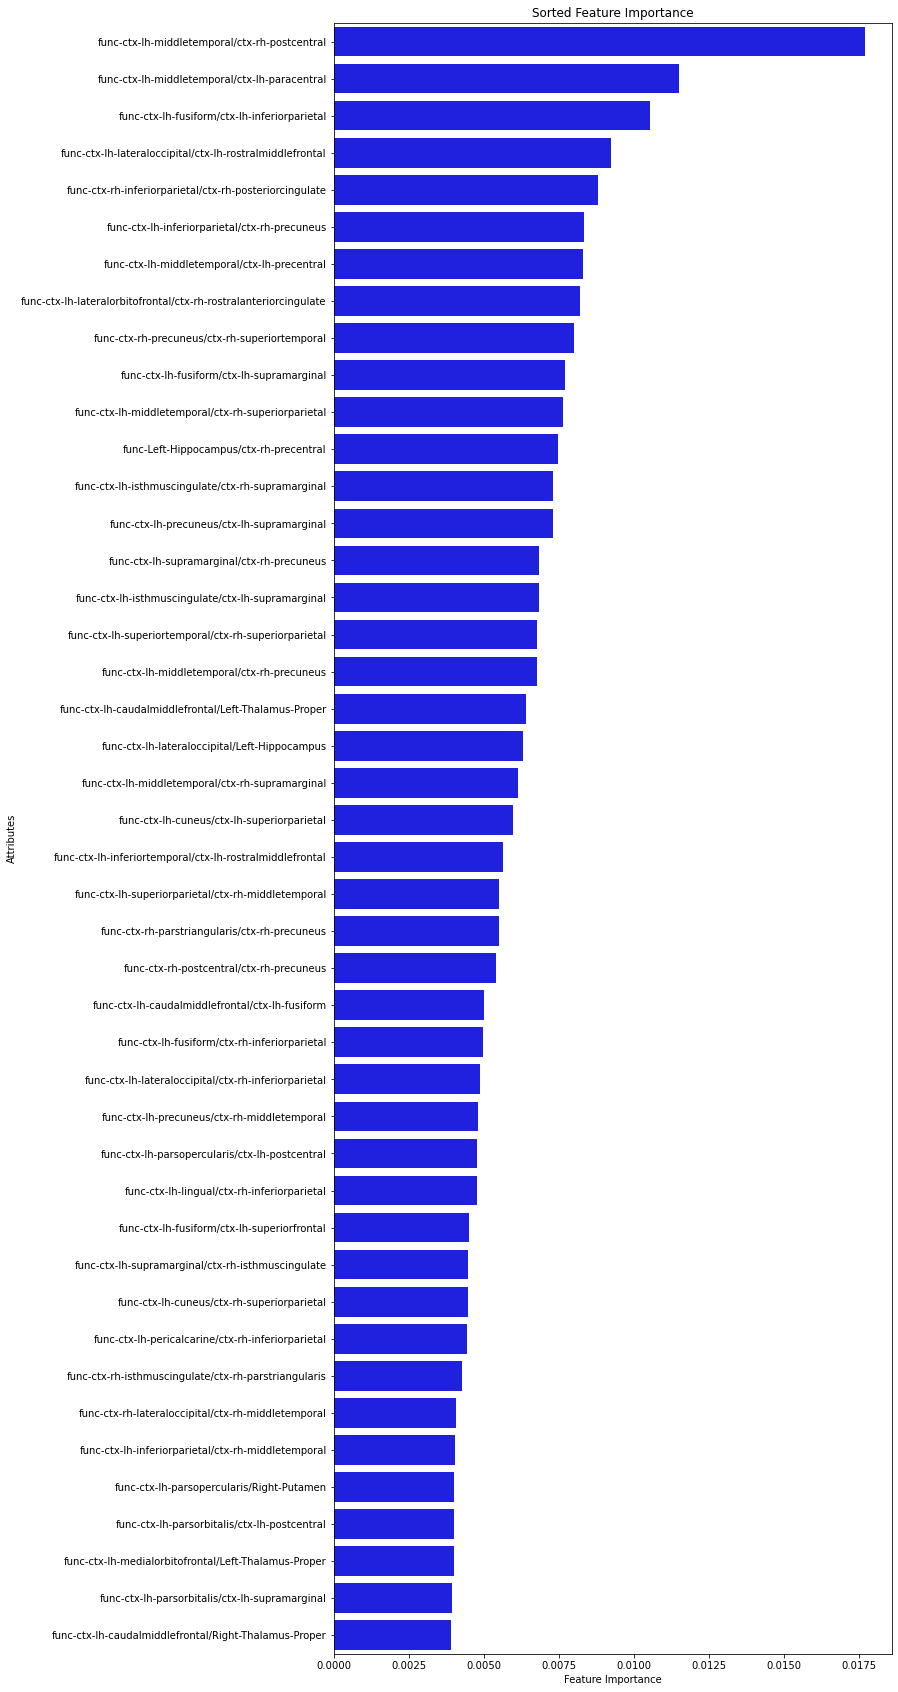

In [104]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=2)
rf.fit(standarized_func, target)

# Feature importance
f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(standarized_func.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

# Visualizing it in a horizontal bar plot
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# Plot
sns.barplot(x='Feature Importance', y=importance_sorted.index,data = importance_sorted,color="b")
ax.set(title= "Sorted Feature Importance",ylabel="Attributes",xlabel="Feature Importance")

In [55]:
rf_columns = [col for col in importance_sorted.index]

evaluation(standarized_func.loc[:, rf_columns[:30]], target) # 13, 15

0.06666666666666667


### **4.5. GM + Func Data**

**4.5.1. Imputation and reference evaluation**

In [56]:
gm_np = np.array(standarized_gm)
func_np = np.array(standarized_func)

gm_final = pd.DataFrame((gm_np + func_np)/2, columns=standarized_fa.columns, index=standarized_fa.index)

ValueError: Shape of passed values is (165, 1798), indices imply (165, 447)

In [ ]:
evaluation(gm_final, target) # 13, 15

In [ ]:
standarized_gm_0 = sc.fit_transform(gm_final)
standarized_gm_0 = pd.DataFrame(standarized_gm_0, index=gm_imputed.index, columns=gm_imputed.columns)

evaluation(standarized_gm_0, target)

**4.5.2. Random Forest Feature Importance**

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=2)
rf.fit(standarized_gm_0, target)

# Feature importance
f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(standarized_gm_0.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

# Visualizing it in a horizontal bar plot
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# Plot
sns.barplot(x='Feature Importance', y=importance_sorted.index,data = importance_sorted,color="b")
ax.set(title= "Sorted Feature Importance",ylabel="Attributes",xlabel="Feature Importance")

In [ ]:
rf_columns = [col for col in importance_sorted.index]

evaluation(standarized_gm_0.loc[:, rf_columns[:21]], target)

### **4.6. FA + GM + Func Data**

**4.6.1. Imputation and reference evaluation**

In [ ]:
fa_np = np.array(standarized_fa)
data = pd.DataFrame(gm_final * fa_np, columns=standarized_fa.columns, index=standarized_fa.index)

evaluation(data, target)

In [ ]:
standarized_fa_0 = sc.fit_transform(data)
standarized_fa_0 = pd.DataFrame(standarized_fa_0, index=gm_imputed.index, columns=gm_imputed.columns)

evaluation(standarized_fa_0, target)

4.6.2. Random Forest Feature Importance

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=2)
rf.fit(standarized_fa_0, target)

# Feature importance
f_imp = pd.Series(rf.feature_importances_)
importance_sorted = pd.DataFrame(list(f_imp), index=list(standarized_fa_0.columns),columns=["Feature Importance"])
importance_sorted = importance_sorted.sort_values('Feature Importance', ascending=False)[:44] # Number of pca features

# Visualizing it in a horizontal bar plot
# sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 30))

# Plot
sns.barplot(x='Feature Importance', y=importance_sorted.index,data = importance_sorted,color="b")
ax.set(title= "Sorted Feature Importance",ylabel="Attributes",xlabel="Feature Importance")

In [ ]:
rf_columns = [col for col in importance_sorted.index]

evaluation(standarized_fa_0.loc[:, rf_columns[:50]], target)

### **To do list:**

* Try different imputation algorithms: RandomForestRegressor, SVM, MICE...

* Correct multicollineality as a last step for preprocessing. This is not going to be meaningful in terms of model performance but it'll help with conclusions.